<a href="https://colab.research.google.com/github/putopavel/practical-application-sentiment-analysis-deep-learning/blob/master/lstm_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install --quiet --upgrade tensorflow-addons texthero
    from google.colab import drive
    import os
    # This will prompt for authorization.
    drive.mount('/content/drive')
    drive_path = "/content/drive/My Drive/TFM"
    os.chdir(drive_path)

     |████████████████████████████████| 1.1MB 7.3MB/s 
     |████████████████████████████████| 1.4MB 26.3MB/s 
     |████████████████████████████████| 245kB 31.0MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import texthero as hero
from texthero import preprocessing
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, LSTM
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def preprocess_tweets(df):
    custom_pipeline = [
        preprocessing.fillna,
        preprocessing.lowercase,
        preprocessing.remove_urls,
        preprocessing.remove_digits,
        preprocessing.remove_punctuation,
        preprocessing.remove_whitespace,
    ]
    df["CLEAN_TWEET"] = df.TWEET.pipe(hero.clean, custom_pipeline)


def preprocess_file(input_filename):
    df = pd.read_csv(input_filename, sep="\t")
    preprocess_tweets(df)
    return df

In [4]:
max_features = 10000
maxlen = 25
batch_size = 100
label_encoder = LabelEncoder()
tokenizer = Tokenizer(num_words=max_features, oov_token = True)

def extract_features(train, val, test):
    tokenizer.fit_on_texts(train.CLEAN_TWEET)
    X_train = pad_sequences(tokenizer.texts_to_sequences(train.CLEAN_TWEET), maxlen = maxlen)
    X_val = pad_sequences(tokenizer.texts_to_sequences(val.CLEAN_TWEET), maxlen = maxlen)
    X_test = pad_sequences(tokenizer.texts_to_sequences(test.CLEAN_TWEET), maxlen = maxlen)

    
    y_train = to_categorical(label_encoder.fit_transform(train.LABEL))
    y_val = to_categorical(label_encoder.fit_transform(val.LABEL))
    y_test = to_categorical(label_encoder.fit_transform(test.LABEL))
    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype="float32")


def get_embedding_matrix(embedding_file, tokenizer, encoding="utf8"):
    embeddings_index = {}
    with open(embedding_file, encoding=encoding) as f:
        num_vectors, vec_dim = map(int, next(f).split(" "))
        for line in tqdm(f, total=num_vectors):
            word, coefs = get_coefs(*line.strip().split(" "))
            embeddings_index[word] = coefs


    all_embs = np.stack(list(embeddings_index.values()))
    embed_mean, embed_std = all_embs.mean(), all_embs.std()

    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))

    embedding_matrix = np.random.normal(embed_mean, embed_std, (nb_words, vec_dim))

    for word, i in word_index.items():
        if i >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            # words not found in embedding index will be random
            embedding_matrix[i] = embedding_vector
    return vec_dim, embedding_matrix

In [6]:
def train_model(vec_dim, embedding_matrix, X_train, y_train, X_val, y_val):
    model = Sequential()
    model.add(Embedding(max_features, vec_dim, weights=[embedding_matrix]))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(40, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.TruePositives(),
        ],
    )

    # Save the model after every epoch.
    saveBestModel = tf.keras.callbacks.ModelCheckpoint(
        "best_model.hdf5", 
        monitor="val_accuracy", 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False, 
        mode="auto", 
        save_freq="epoch"
    )
    # Stop training when a monitored quantity has stopped improving.
    earlyStopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0, 
        patience=3, 
        verbose=0, 
        mode="auto"
    )

    model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=25,
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[saveBestModel, earlyStopping, tfa.callbacks.TQDMProgressBar()],
    )
    return model

# Spanish dataset

In [7]:
spanish_train = preprocess_file("spanish_train.csv")
spanish_val = preprocess_file("spanish_val.csv")
spanish_test = preprocess_file("spanish_test.csv")

X_train, y_train, X_val, y_val, X_test, y_test = extract_features(spanish_train, spanish_val, spanish_test)

In [8]:
%%timeit -r 1 -n 1
embedding_file = "embeddings-l-model.vec"
vec_dim, embedding_matrix = get_embedding_matrix(embedding_file, tokenizer)

model = train_model(vec_dim, embedding_matrix, X_train, y_train, X_val, y_val)
pred_y = np.argmax(model.predict(X_test, batch_size=batch_size), axis=-1)
spanish_test["PRED_LABEL"] = label_encoder.inverse_transform(pred_y)
print(classification_report(spanish_test["LABEL"], spanish_test["PRED_LABEL"]))

Epoch 1/25



Epoch 2/25



Epoch 3/25



Epoch 4/25



Epoch 5/25



Epoch 6/25



Epoch 7/25



Epoch 8/25




              precision    recall  f1-score   support

     AGAINST       0.64      0.75      0.69       829
       FAVOR       0.68      0.63      0.66       807
     NEUTRAL       0.87      0.69      0.77       380

    accuracy                           0.69      2016
   macro avg       0.73      0.69      0.71      2016
weighted avg       0.70      0.69      0.69      2016

1 loop, best of 1: 3min 36s per loop


# Catalan dataset

In [9]:
catalan_train = preprocess_file("catalan_train.csv")
catalan_val = preprocess_file("catalan_val.csv")
catalan_test = preprocess_file("catalan_test.csv")

X_train, y_train, X_val, y_val, X_test, y_test = extract_features(catalan_train, catalan_val, catalan_test)

In [10]:
%%timeit -r 1 -n 1
embedding_file = "embeddings-l-model.vec"
vec_dim, embedding_matrix = get_embedding_matrix(embedding_file, tokenizer, "latin-1")

model = train_model(vec_dim, embedding_matrix, X_train, y_train, X_val, y_val)
pred_y = np.argmax(model.predict(X_test, batch_size=batch_size), axis=-1)
catalan_test["PRED_LABEL"] = label_encoder.inverse_transform(pred_y)
print(classification_report(catalan_test["LABEL"], catalan_test["PRED_LABEL"]))

Epoch 1/25



Epoch 2/25



Epoch 3/25



Epoch 4/25



Epoch 5/25



Epoch 6/25



Epoch 7/25



Epoch 8/25




              precision    recall  f1-score   support

     AGAINST       0.65      0.67      0.66       752
       FAVOR       0.70      0.70      0.70       804
     NEUTRAL       0.62      0.59      0.60       454

    accuracy                           0.66      2010
   macro avg       0.66      0.65      0.65      2010
weighted avg       0.66      0.66      0.66      2010

1 loop, best of 1: 2min 51s per loop


In [11]:
combined_train = pd.concat((spanish_train, catalan_train))
combined_val = pd.concat((spanish_val, catalan_val))
combined_test = pd.concat((spanish_test, catalan_test))

X_train, y_train, X_val, y_val, X_test, y_test = extract_features(combined_train, combined_val, combined_test)

In [12]:
%%timeit -r 1 -n 1
embedding_file = "embeddings-l-model.vec"
vec_dim, embedding_matrix = get_embedding_matrix(embedding_file, tokenizer)

model = train_model(vec_dim, embedding_matrix, X_train, y_train, X_val, y_val)
pred_y = np.argmax(model.predict(X_test, batch_size=batch_size), axis=-1)
combined_test["PRED_LABEL"] = label_encoder.inverse_transform(pred_y)
print(classification_report(combined_test["LABEL"], combined_test["PRED_LABEL"]))

Epoch 1/25



Epoch 2/25



Epoch 3/25



Epoch 4/25



Epoch 5/25



Epoch 6/25



Epoch 7/25




              precision    recall  f1-score   support

     AGAINST       0.65      0.64      0.65      1581
       FAVOR       0.65      0.70      0.67      1611
     NEUTRAL       0.73      0.64      0.68       834

    accuracy                           0.66      4026
   macro avg       0.68      0.66      0.67      4026
weighted avg       0.67      0.66      0.66      4026

1 loop, best of 1: 3min 17s per loop


# Confusion Matrices

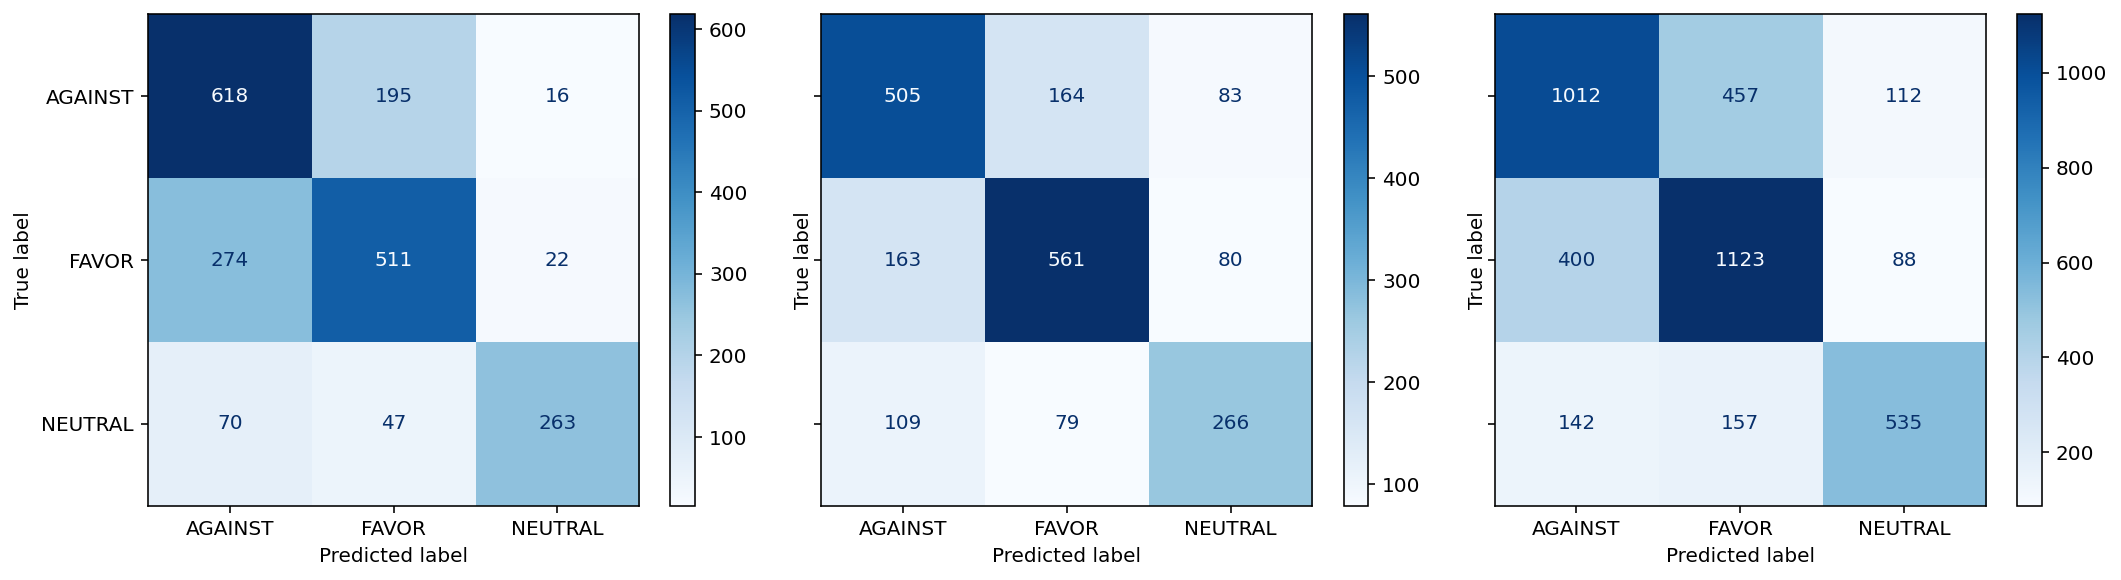

In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

cf = confusion_matrix(spanish_test.LABEL, spanish_test.PRED_LABEL)
cf_disp = ConfusionMatrixDisplay(cf, spanish_test.LABEL.unique())
cf_disp.plot(cmap="Blues", ax=ax[0], xticks_rotation="horizontal", values_format="d")

cf = confusion_matrix(catalan_test.LABEL, catalan_test.PRED_LABEL)
cf_disp = ConfusionMatrixDisplay(cf, catalan_test.LABEL.unique())
cf_disp.plot(cmap="Blues", ax=ax[1], xticks_rotation="horizontal", values_format="d")

cf = confusion_matrix(combined_test.LABEL, combined_test.PRED_LABEL)
cf_disp = ConfusionMatrixDisplay(cf, combined_test.LABEL.unique())
cf_disp.plot(cmap="Blues", ax=ax[2], xticks_rotation="horizontal", values_format="d")

fig.tight_layout()